In [1]:
import logging
import os
from pprint import pprint

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

In [19]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [22]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s - %(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [3]:
logger = logging.getLogger(__name__)

In [4]:
logging.getLogger(__name__).setLevel("DEBUG")
logging.getLogger("dask").setLevel("INFO")
logging.getLogger("gcsfs").setLevel("INFO")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [5]:
!gsutil ls gs://liulab/data/pseudobulk_optimization

gs://liulab/data/pseudobulk_optimization/1_no_qc_subset/
gs://liulab/data/pseudobulk_optimization/2_no_qc/
gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/


In [6]:
uri_pseudobulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures"

!gsutil ls -lhR {uri_pseudobulks} | grep data.parquet | head

 31.03 MiB  2022-05-26T05:32:30Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=1/malignant_from_one_sample=False/data.parquet
 30.76 MiB  2022-05-26T05:32:14Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=1/malignant_from_one_sample=True/data.parquet
  42.6 MiB  2022-05-26T05:36:22Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=10/malignant_from_one_sample=False/data.parquet
 42.33 MiB  2022-05-26T05:36:04Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=10/malignant_from_one_sample=True/data.parquet
 42.82 MiB  2022-05-26T05:36:51Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=11/malignant_from_one_sample=False/data.parquet
 42.59 MiB  2022-05-26T05:36:40Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=11/malignant_from_one_sample=True/data.parquet
 43.14 MiB  2022-05-26T05:37:26Z  gs://liulab/data/pseudobulk_optimization/

In [7]:
pseudobulks = dd.read_parquet(uri_pseudobulks, engine="pyarrow")

In [8]:
uri_real_bulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet"
real_bulks = dd.read_parquet(uri_real_bulks, engine="pyarrow")

In [9]:
merged = dd.merge(
    pseudobulks,
    real_bulks,
    how="inner",
    left_on=["gene_symbol", "tcga_aliquot_barcode_for_fractions"],
    right_on=["gene_symbol", "aliquot_barcode"],
    suffixes=["_pseudo", "_real"],
)

In [10]:
merged.head()

,gene_symbol,tcga_aliquot_barcode_for_fractions,tpm_pseudo,n_cells,malignant_from_one_sample,aliquot_barcode,tpm_real
0,A1BG,TCGA-3N-A9WB-06A-11R-A38C-07,0.000000,1,False,TCGA-3N-A9WB-06A-11R-A38C-07,18.646752
1,A1BG,TCGA-3N-A9WC-06A-11R-A38C-07,0.000000,1,False,TCGA-3N-A9WC-06A-11R-A38C-07,11.422884
2,A1BG,TCGA-3N-A9WD-06A-11R-A38C-07,34.628728,1,False,TCGA-3N-A9WD-06A-11R-A38C-07,14.801890
3,A1BG,TCGA-BF-AAP0-06A-11R-A39D-07,19.270166,1,False,TCGA-BF-AAP0-06A-11R-A39D-07,29.493640
4,A1BG,TCGA-D3-A1Q1-06A-21R-A18T-07,0.661639,1,False,TCGA-D3-A1Q1-06A-21R-A18T-07,20.790625


In [12]:
merged.dtypes

gene_symbol                           category
tcga_aliquot_barcode_for_fractions    category
tpm_pseudo                             float64
n_cells                               category
malignant_from_one_sample             category
aliquot_barcode                       category
tpm_real                               float64
dtype: object

In [13]:
merged.sample(frac=0.001).compute()

,gene_symbol,tcga_aliquot_barcode_for_fractions,tpm_pseudo,n_cells,malignant_from_one_sample,aliquot_barcode,tpm_real
1853337,FN1,TCGA-DA-A1HV-06A-21R-A18S-07,11.416751,1,False,TCGA-DA-A1HV-06A-21R-A18S-07,526.450090
2096120,GPSM2,TCGA-YD-A89C-06A-11R-A37K-07,0.000000,1,False,TCGA-YD-A89C-06A-11R-A37K-07,11.281902
4066984,PXMP2,TCGA-ER-A195-06A-11R-A18U-07,0.000000,1,False,TCGA-ER-A195-06A-11R-A18U-07,32.140063
4106382,RABAC1,TCGA-ER-A1A1-06A-11R-A18U-07,496.905049,1,False,TCGA-ER-A1A1-06A-11R-A18U-07,221.561198
140186,AIFM1,TCGA-WE-A8K6-06A-11R-A37K-07,45.165072,1,False,TCGA-WE-A8K6-06A-11R-A37K-07,40.405194
...,...,...,...,...,...,...,...
3538451,OSBPL7,TCGA-EE-A20F-06A-21R-A18S-07,55.779527,20,True,TCGA-EE-A20F-06A-21R-A18S-07,6.071269
3321353,NDUFB1,TCGA-EE-A2A1-06A-11R-A18T-07,134.459410,20,True,TCGA-EE-A2A1-06A-11R-A18T-07,126.289604
4560150,SHISA5,TCGA-FS-A1YW-06A-11R-A18T-07,263.435503,20,True,TCGA-FS-A1YW-06A-11R-A18T-07,179.165608
313108,ARL4C,TCGA-GN-A264-06A-11R-A18U-07,8.345361,20,True,TCGA-GN-A264-06A-11R-A18U-07,34.707630


In [14]:
merged_groupby = merged.groupby(["n_cells", "malignant_from_one_sample"])

In [20]:
def compute_comparison_metrics(df: pd.DataFrame) -> pd.Series:
    gene_means = df.groupby("gene_symbol")[["tpm_pseudo", "tpm_real"]].mean()
    ks_test_results = scipy.stats.ks_2samp(
        gene_means["tpm_pseudo"], gene_means["tpm_real"]
    )
    return pd.Series(
        {
            "corr_linear": np.corrcoef(df["tpm_pseudo"], df["tpm_real"])[0, 1],
            "corr_rank": scipy.stats.spearmanr(df["tpm_pseudo"], df["tpm_real"])[0],
            "ks_test_stat": ks_test_results[0],
            # "ks_test_pval_neg_log10": -np.log10(ks_test_results[1]),
        }
    )


metadata = [
    ("corr_linear", "float64"),
    ("corr_rank", "float64"),
    ("ks_test_stat", "float64"),
    # ("ks_test_pval_neg_log10", "float64"),
]
results = (
    merged_groupby.apply(compute_comparison_metrics, meta=metadata).dropna().compute()
)
results = results.sort_index()

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/lib/function_base.py:495: RuntimeWarning:

Mean of empty slice.

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning:

divide by zero encountered in true_divide

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning:

invalid value encountered in multiply

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/lib/function_base.py:495: RuntimeWarning:

Mean of empty slice.

/opt/conda/envs/deconv/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/envs/deconv/lib/python3.10/site-packages/n

In [16]:
import plotly.express as px
import plotly.graph_objects as go

2022-05-30 21:32:03,131 15705/MainThread __main__ DEBUG - adding trace: corr_rank, malignants from all samples
2022-05-30 21:32:03,136 15705/MainThread __main__ DEBUG - adding trace: corr_rank, malignants from one sample
2022-05-30 21:32:03,141 15705/MainThread __main__ DEBUG - adding trace: corr_linear, malignants from all samples
2022-05-30 21:32:03,146 15705/MainThread __main__ DEBUG - adding trace: corr_linear, malignants from one sample
2022-05-30 21:32:03,151 15705/MainThread __main__ DEBUG - adding trace: ks_test_stat, malignants from all samples
2022-05-30 21:32:03,156 15705/MainThread __main__ DEBUG - adding trace: ks_test_stat, malignants from one sample


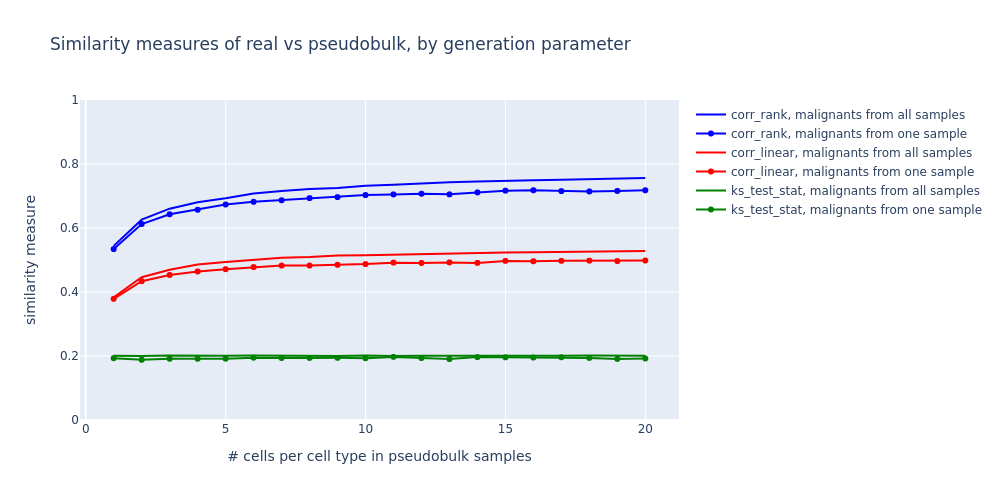

In [24]:
fig = go.Figure()
modes = {"True": "lines+markers", "False": "lines"}
for column, color in zip(results.columns[[1, 0, 2]], ["blue", "red", "green"]):
    for malignant in results.index.unique(level="malignant_from_one_sample"):
        malignant_label = "one sample" if malignant == "True" else "all samples"
        trace_name = f"{column}, malignants from {malignant_label}"
        subset = (
            results.query(f"malignant_from_one_sample == '{malignant}'")
            .sort_index()
            .reset_index()
        )
        logger.debug(f"adding trace: {trace_name}")
        fig.add_trace(
            go.Scatter(
                x=subset["n_cells"],
                y=subset[column],
                mode=modes[malignant],
                name=trace_name,
                line_color=color,
            )
        )
fig.update_layout(
    title="Similarity measures of real vs pseudobulk, by generation parameter"
)
fig = fig.update_yaxes(range=[0, 1], title="similarity measure")
fig = fig.update_xaxes(title="# cells per cell type in pseudobulk samples")

fig.show(width=1000, renderer="png")
# fig

In [ ]:
subset[column].index

In [ ]:
# fig.add_trace(go.Scatter(x=random_x, y=random_y1,
#                     mode='lines+markers',
#                     name='lines+markers'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y2,
#                     mode='markers', name='markers'))

In [ ]:
_ = results.iloc[:, :3].unstack(level=-1)
_.columns = [" ".join(col).strip() for col in _.columns.values]
_

In [ ]:
fig = px.line(_, color_discrete_map=["blue", "red"])

fig.show(renderer="png")